# Training

In [1]:
import numpy as np

X = np.load('X.npy', encoding='latin1')
y = np.load('y.npy', encoding='latin1')

In [2]:
def map_notes_to_one_octave(note_values):
    output = np.array(note_values)
    for i in range(0, len(note_values)):
        note = note_values[i]
        if(note == 0):
            output[i] = -1
        else:
            output[i] = note%12
    return output

one_octave_X = np.zeros((len(X), len(X[0])))
for i in range(0, len(X)):
    one_octave_X[i] = map_notes_to_one_octave(X[i])
    
one_octave_y = np.zeros((len(y), len(y[0])))
for i in range(0, len(y)):
    one_octave_y[i] = map_notes_to_one_octave(y[i])

In [3]:
X = one_octave_X
y = one_octave_y

In [4]:
''' functions to encode phrase from notes to one-hot vectors'''

number_of_notes = len(X[0])

def note_values_to_one_hot_phrase(note_values):
    note_values = map_notes_to_one_octave(note_values)
    ''' 12 is 0, 13 is start, 14 is end '''
    ''' values are between 0 and 11'''
    one_hot_phrase = np.zeros((number_of_notes+2, 15))
    'start of sequence'
    one_hot_phrase[0][13] = 1 
    for i in range (1, len(note_values)+1):
        note = int(note_values[i-1])
        one_hot_note = np.zeros(15)
        if(note == -1):
            one_hot_note[12] = 1
        else:
            one_hot_note[note] = 1
        one_hot_phrase[i] = one_hot_note
    'end of sequence'
    one_hot_phrase[-1][14] = 1 
        
    return one_hot_phrase

def one_hot_phrase_to_note_values(one_hot_phrase):
    ''' 12 is 0, 13 is start, 14 is end '''
    note_values = np.zeros((number_of_notes+2, 1))
    for i in range(0, len(one_hot_phrase)):
        index, = np.where(one_hot_phrase[i] == 1)
        if(len(index) == 0):
            continue
        if(index[0] == 12):
            note_values[i] = 0 
        elif(index[0] == 13):
            note_values[i] = -1
        elif(index[0] == 14):
            note_values[i] = -2
        else:
            note_values[i] = index[0]
    return note_values

In [5]:
''' Encode data into k-array with 0 in all position except one 1
    index is the note value
    
    [
        [10, 10, 11, ...] => [0, 0, 0, ... 1, 0, 0, 0, 0],
                             [0, 0, 0, ... 1, 0, 0, 0, 0],
                             [0, 0, 0, ... 0, 1, 0, 0, 0], 
        ...
    ]
'''
one_hot_X = np.zeros((len(X), number_of_notes+2, 15))
for i in range(0, len(X)):
    one_hot_X[i] = note_values_to_one_hot_phrase(X[i])

one_hot_y = np.zeros((len(y), number_of_notes+2, 15))
for i in range(0, len(y)):
    one_hot_y[i] = note_values_to_one_hot_phrase(y[i])
    
X = one_hot_X
y = one_hot_y

In [6]:
''' split dataset into train and test sets '''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(one_hot_X, one_hot_y, 
                                                    test_size=0.20, random_state=42)

print(len(X_train))
print(len(y_test))

28579
7145


In [7]:
print(one_hot_phrase_to_note_values(X_train[10]).T)

print(one_hot_phrase_to_note_values(X_test[0]).T)

[[-1.  5.  5.  5.  5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 11.  2.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  2.  2.  2. 11.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10.
  10. 10. 10. 10. 10.  0.  0.  0.  0.  0.  0. -2.]]
[[-1.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  8.  8.  8.
   8.  8.  8.  8.  8.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
   7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7. -2.]]


In [8]:
''' create encoder input, decoder input and decoder target sets from training data '''

''' 
    here the decoder_target_data is equal to decoder_input_data shifted one step.
    this way the decoder rnn learns to get decoder_input_target from decoder_input_data
    decoder_target_data[i] = decoder_input_data[i+1] 
# '''

encoder_input_data = X_train
decoder_input_data = np.zeros((len(y_train), number_of_notes+2, 15), dtype=object)
decoder_target_data = np.zeros((len(y_train), number_of_notes+2, 15), dtype=object)

for i in range (0, len(y_train)):
    decoder_input_data[i] = np.zeros((number_of_notes+2, 15))
    
    for j in range(1, number_of_notes+1):
        decoder_input_data[i][j] = y_train[i][j-1]
        
    decoder_input_data[i][0][13] = 1
    decoder_input_data[i][-1][14] = 1
    
    decoder_target_data[i] = np.zeros((number_of_notes+2, 15))
    
    for j in range(0, len(decoder_input_data[i])-1):
        decoder_target_data[i][j] = decoder_input_data[i][j+1]
    
encoder_input_data = np.array(encoder_input_data, dtype='float32')
decoder_input_data = np.array(decoder_input_data, dtype='float32')
decoder_target_data = np.array(decoder_target_data, dtype='float32')

In [9]:
print(len(decoder_target_data[10]))
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

66
(28579, 66, 15)
(28579, 66, 15)
(28579, 66, 15)


In training CuDNNLSTM is used but the weights can be used with regular LSTM

In [2]:
# ''' define rnn model '''
from keras.models import Model
from keras.layers import Input, Dense, LSTM, CuDNNLSTM
from keras import metrics, regularizers

units = 1000

'layer 1 is the encoder'
encoder_inputs = Input(shape=(None, 15))
encoder = LSTM(units, return_state=True)
encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_inputs)
'encoder_outputs wont be used'

'layer 2 is the decoder'
decoder_inputs = Input(shape=(None, 15))
decoder = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_h, decoder_state_c = decoder(
    decoder_inputs, initial_state=[encoder_state_h, encoder_state_c])

'layer 3 is a softmax layer for output'
decoder_dense = Dense(15, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
              metrics=[metrics.categorical_accuracy])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 15)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 15)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 1000), (None 4064000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 1000), 4064000     input_2[0][0]                    
                                     

In [12]:
''' train model on train data'''
record = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_split=0.2)

Train on 22863 samples, validate on 5716 samples
Epoch 1/50
22863/22863 [==============================] - 25s 1ms/step - loss: 1.0671 - categorical_accuracy: 0.7221 - val_loss: 0.7854 - val_categorical_accuracy: 0.8150
Epoch 2/50
22863/22863 [==============================] - 22s 961us/step - loss: 0.5420 - categorical_accuracy: 0.8521 - val_loss: 0.5232 - val_categorical_accuracy: 0.8510
Epoch 3/50
22863/22863 [==============================] - 22s 961us/step - loss: 0.4639 - categorical_accuracy: 0.8627 - val_loss: 0.4551 - val_categorical_accuracy: 0.8682
Epoch 4/50
22863/22863 [==============================] - 22s 962us/step - loss: 0.4196 - categorical_accuracy: 0.8726 - val_loss: 0.4211 - val_categorical_accuracy: 0.8738
Epoch 5/50
22863/22863 [==============================] - 22s 962us/step - loss: 0.3862 - categorical_accuracy: 0.8793 - val_loss: 0.3932 - val_categorical_accuracy: 0.8786
Epoch 6/50
22863/22863 [==============================] - 22s 964us/step - loss: 0.3514 

Epoch 48/50
22863/22863 [==============================] - 22s 964us/step - loss: 0.1071 - categorical_accuracy: 0.9516 - val_loss: 0.3457 - val_categorical_accuracy: 0.9109
Epoch 49/50
22863/22863 [==============================] - 22s 960us/step - loss: 0.1040 - categorical_accuracy: 0.9526 - val_loss: 0.3547 - val_categorical_accuracy: 0.9093
Epoch 50/50
22863/22863 [==============================] - 22s 966us/step - loss: 0.0996 - categorical_accuracy: 0.9536 - val_loss: 0.3563 - val_categorical_accuracy: 0.9095


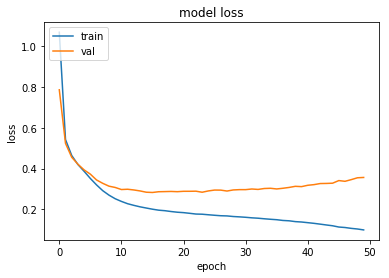

In [14]:
''' learning curve '''
import matplotlib.pyplot as plt

plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

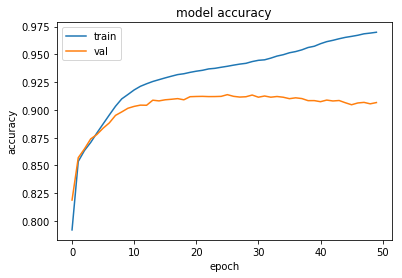

In [17]:
''' learning curve '''
import matplotlib.pyplot as plt

plt.plot(record.history['categorical_accuracy'])
plt.plot(record.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
'''
    setup test set and run model on it
'''

encoder_input_data_test = X_test
decoder_input_data_test = np.zeros((len(y_test), number_of_notes+2, 15), dtype=object)
decoder_target_data_test = np.zeros((len(y_test), number_of_notes+2, 15), dtype=object)

for i in range (0, len(y_test)):
    decoder_input_data_test[i] = np.zeros((number_of_notes+2, 15))
    
    for j in range(1, number_of_notes+1):
        decoder_input_data_test[i][j] = y_test[i][j-1]
        
    decoder_input_data_test[i][0][13] = 1
    decoder_input_data_test[i][-1][14] = 1
    
    decoder_target_data_test[i] = np.zeros((number_of_notes+2, 15))
    
    for j in range(0, len(decoder_input_data[i])-1):
        decoder_target_data_test[i][j] = decoder_input_data_test[i][j+1]
    
encoder_input_data_test = np.array(encoder_input_data_test, dtype='float32')
decoder_input_data_test = np.array(decoder_input_data_test, dtype='float32')
decoder_target_data_test = np.array(decoder_target_data_test, dtype='float32')
        
score = model.evaluate([encoder_input_data_test, decoder_input_data_test],
                       decoder_target_data_test)
score

7145/7145 [==============================] - 3s 367us/step


[0.41530972985307013, 0.9074156548361247]

In [19]:
''' train model on whole dataset'''

encoder_input_whole_data = X
decoder_input_whole_data = np.zeros((len(y), number_of_notes+2, 15), dtype=object)
decoder_target_whole_data = np.zeros((len(y), number_of_notes+2, 15), dtype=object)

for i in range (0, len(y)):
    decoder_input_whole_data[i] = np.zeros((number_of_notes+2, 15))
    
    for j in range(1, number_of_notes+1):
        decoder_input_whole_data[i][j] = y[i][j-1]
        
    decoder_input_whole_data[i][0][13] = 1
    decoder_input_whole_data[i][-1][14] = 1
    
    decoder_target_whole_data[i] = np.zeros((number_of_notes+2, 15))
    
    for j in range(0, len(decoder_input_whole_data[i])-1):
        decoder_target_whole_data[i][j] = decoder_input_whole_data[i][j+1]
    
encoder_input_whole_data = np.array(encoder_input_whole_data, dtype='float32')
decoder_input_whole_data = np.array(decoder_input_whole_data, dtype='float32')
decoder_target_whole_data = np.array(decoder_target_whole_data, dtype='float32')


record = model.fit([encoder_input_whole_data, decoder_input_whole_data], 
          decoder_target_whole_data,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_split=0)
model_name = 'lstm_units_1000_batch_64_whole_dataset.h5'
model.save(model_name)

Epoch 1/50
35724/35724 [==============================] - 31s 871us/step - loss: 0.1636 - categorical_accuracy: 0.9442
Epoch 2/50
35724/35724 [==============================] - 31s 871us/step - loss: 0.1221 - categorical_accuracy: 0.9513
Epoch 3/50
35724/35724 [==============================] - 31s 868us/step - loss: 0.1021 - categorical_accuracy: 0.9555
Epoch 4/50
35724/35724 [==============================] - 31s 871us/step - loss: 0.0886 - categorical_accuracy: 0.9585
Epoch 5/50
35724/35724 [==============================] - ETA: 0s - loss: 0.0776 - categorical_accuracy: 0.96 - 31s 869us/step - loss: 0.0776 - categorical_accuracy: 0.9612
Epoch 6/50
35724/35724 [==============================] - 31s 870us/step - loss: 0.0695 - categorical_accuracy: 0.9633
Epoch 7/50
35724/35724 [==============================] - 31s 868us/step - loss: 0.0633 - categorical_accuracy: 0.9650
Epoch 8/50
35724/35724 [==============================] - 31s 871us/step - loss: 0.0561 - categorical_accuracy: 0

/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 1000) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Prediction

In [3]:
'''
    setup prediction model using trained weights, first copmile model
'''

import numpy as np

# ''' define rnn model '''
from keras.models import Model
from keras.layers import Input, Dense, LSTM, CuDNNLSTM
from keras import metrics, regularizers

units = 1000

'layer 1 is the encoder'
encoder_inputs = Input(shape=(None, 15))
encoder = LSTM(units, return_state=True)
encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_inputs)
'encoder_outputs wont be used'

'layer 2 is the decoder'
decoder_inputs = Input(shape=(None, 15))
decoder = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_h, decoder_state_c = decoder(
    decoder_inputs, initial_state=[encoder_state_h, encoder_state_c])

'layer 3 is a softmax layer for output'
decoder_dense = Dense(15, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
              metrics=[metrics.categorical_accuracy])

def map_notes_to_one_octave(note_values):
    output = np.array(note_values)
    for i in range(0, len(note_values)):
        note = note_values[i]
        if(note == 0):
            output[i] = -1
        else:
            output[i] = note%12
    return output


encoder_model = Model(encoder_inputs, [encoder_state_h, encoder_state_c])

decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

'function to take sequence of note values and return another one'
'input_seq is (1, 128, 57)'
'output is (128, 57)'

def decode_sequence(input_seq):
    'run encoder to get the state that will be input for the decoder'
    states_value = encoder_model.predict(input_seq)
    
    'decode starts start of sequence vector'
    target = np.zeros((1, 1, 15))
    target[0, 0, 13] = 1
    
    'decoded_sequence contains notes in the output'
    decoded_sequence = np.zeros((number_of_notes, 15))
        
    'loop generates 64 notes'
    for i in range(0, number_of_notes):
        'running decoder to predict next value given target note and input state'
        output_note, h, c = decoder_model.predict([target] + states_value)
        
        'getting note with highest softmax value'
        note_index = np.argmax(output_note)
        
        'updating output sequence'
        decoded_sequence[i, note_index] = 1 
        
        'setting next target to be the previous note'
        target = np.zeros((1, 1, 15))            
        target[0, 0, note_index] = 1
        'updating the decoder input for next iteration'
        states_value = [h, c]
        
    return decoded_sequence

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 15)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 15)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 1000), (None 4064000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 1000), 4064000     input_4[0][0]                    
                                                                 lstm_3[0][1]                     
          

In [6]:
'''
    read input sequence and write an output sequence that can later be transformed into midi
'''

number_of_notes = 64

def note_values_to_one_hot_phrase(note_values):
    note_values = map_notes_to_one_octave(note_values)
    ''' 12 is 0, 13 is start, 14 is end '''
    ''' values are between 0 and 11'''
    one_hot_phrase = np.zeros((number_of_notes+2, 15))
    'start of sequence'
    one_hot_phrase[0][13] = 1 
    for i in range (1, len(note_values)+1):
        note = int(note_values[i-1])
        one_hot_note = np.zeros(15)
        if(note == -1):
            one_hot_note[12] = 1
        else:
            one_hot_note[note] = 1
        one_hot_phrase[i] = one_hot_note
    'end of sequence'
    one_hot_phrase[-1][14] = 1 
        
    return one_hot_phrase

def one_hot_phrase_to_note_values(one_hot_phrase):
    ''' 12 is 0, 13 is start, 14 is end '''
    note_values = np.zeros((number_of_notes+2, 1))
    for i in range(0, len(one_hot_phrase)):
        index, = np.where(one_hot_phrase[i] == 1)
        if(len(index) == 0):
            continue
        if(index[0] == 12):
            note_values[i] = 0 
        elif(index[0] == 13):
            note_values[i] = -1
        elif(index[0] == 14):
            note_values[i] = -2
        else:
            note_values[i] = index[0]
    return note_values

model.load_weights('lstm_units_1000_batch_64_whole_dataset.h5')

custom_input = np.zeros((1, number_of_notes+2, 15))
custom_output = np.zeros((1, number_of_notes+2, 15))
custom_input[0] = note_values_to_one_hot_phrase(np.load('custom_input.npy'))
custom_output = decode_sequence(custom_input)

print(one_hot_phrase_to_note_values(custom_input[0]).T)
print(one_hot_phrase_to_note_values(custom_output).T)

np.save('custom_output.npy', np.asarray(
    one_hot_phrase_to_note_values(custom_output).T, dtype='int'))

[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  4.
   4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  6.  6.  6.  6.  6.
   6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6. -2.]]
[[-1.  0. 11.  6.  6.  6.  6.  6.  6. 11.  8.  8.  8.  8.  8.  8.  8. 10.
  10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
  10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
  11. 11. 11. 11. 11. 11. 11. 11. 11. 11.  0.  0.]]
